In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from import_for_notebooks import *
torch.set_default_dtype(torch.float32)

import common_utils
import analysis
import analysis_utils
from analysis import find_nearest_neighbour, scale, sort_by_metric

c:\Users\91755\anaconda3_1\envs\project_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


IMPORTANT IMPORTED! 2023-09-18 09:22:05.729967
device=cpu


In [2]:
# in case you have your own sweep:
# sweep_id = '3s9e7mys'
# sweeps_dir = './data/sweeps/'
# sweep = analysis_utils.read_sweep(sweeps_dir, sweep_id, name=None, problem='cifar10_vehicles_animals')
# analysis_utils.download_sweep_results_from_wandb(sweep, max_runs_to_download=100)
# X = analysis_utils.get_all_reconstruction_outputs(sweep, verbose=True)

# read sweep parameters
sweep = common_utils.common.load_dict_to_obj("./reconstructions/cifar10_vehicles_animals/sweep-cnn.txt")
# read model, data, and whatever needed
args, Xtrn, Ytrn, ds_mean, W, model = analysis_utils.sweep_get_data_model(sweep, put_in_sweep=True, run_train_test=True)

OUTPUT_DIR: C:/Users/91755/Documents/Files\2023_09_18_09_22_07_760509_cifar10_vehicles_animals_d250
Namespace(cls_type='multi', cuda=True, data_per_class_test=1000, data_per_class_train=250, data_per_class_val=0, data_reduce_mean=True, datasets_dir='C:/Users/91755/Documents/Geetha Ranganathan/Coursework/Dissertation/Source Code/data_reconstruction/data/', device=device(type='cpu'), extract_save_results=True, extract_save_results_every=10000, extraction_data_amount_per_class=500, extraction_epochs=50000, extraction_evaluate_rate=1000, extraction_init_scale=1e-09, extraction_lambda_lr=0.0001, extraction_loss_type='kkt', extraction_lr=0.0001, extraction_lr_l=0.0001, extraction_lr_x=0.0001, extraction_min_lambda=0.05, extraction_model_activation='modifiedrelu', extraction_model_relu_alpha=300, extraction_stop_threshold=5000, metric='dssim', model_hidden_list=[1000, 1000], model_init_list=[0.001, 0.001], model_name='cifar10_vehicles_animals_d250', model_train_activation='relu', model_train_

100%|██████████| 170498071/170498071 [00:12<00:00, 13417641.08it/s]


Extracting C:/Users/91755/Documents/Geetha Ranganathan/Coursework/Dissertation/Source Code/data_reconstruction/data/cifar-10-python.tar.gz to C:/Users/91755/Documents/Geetha Ranganathan/Coursework/Dissertation/Source Code/data_reconstruction/data/
BALANCING DATASET...
LOADING TESTSET
Files already downloaded and verified
BALANCING DATASET...
X: torch.Size([500, 3, 32, 32])
y: torch.Size([500])
X: torch.Size([1000, 3, 32, 32])
y: torch.Size([1000])
Initializing model weights - Only First Layer
Parameters per Layer: [tensor(450), tensor(6), tensor(2400), tensor(16), tensor(48000), tensor(120), tensor(10080), tensor(84), tensor(840), tensor(10)]
Total Parameters: 62006
loading weights 'C:/Users/91755/Documents/Geetha Ranganathan/Coursework/Dissertation/Source Code/data_reconstruction/models/cnn-output/7polvc6e.pth'
device  cpu

Model CNN MNet(
  (layers): ModuleList(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, paddin

In [3]:
# Read Reconstructed Data:

# "X" will contain a batch of all reconstructed samples (not all of them are good.. for this we need the rest of the cell)
# Here we put reconstructed data from two diffferent runs.
# you can use both of them or just one. (uncomment relevant parts)
x_paths = [
    # './latestruns/2023_09_18_03_35_12_264757_cifar10_vehicles_animals_d250/x/8000_x.pth',
    # './latestruns/2023_09_18_03_46_31_976479_cifar10_vehicles_animals_d250/x/9000_x.pth',
    './reconstructions/cifar10_vehicles_animals/x/hlbx7hhh.pth'
]
X = torch.load(x_paths[0], map_location=torch.device('cpu'))
# X = torch.load(x_paths[1], map_location=torch.device('cpu'))
# X = torch.cat([torch.load(x_paths[0],map_location=torch.device('cpu')), torch.load(x_paths[1],map_location=torch.device('cpu')),torch.load(x_paths[0],map_location=torch.device('cpu')),torch.load(x_paths[0],map_location=torch.device('cpu'))])

CUT the end of the zipped bla because it might have different shape before torch.cat
torch.Size([960, 3, 32, 32]) 48


  0%|          | 0/12 [00:00<?, ?it/s]

0 0 80


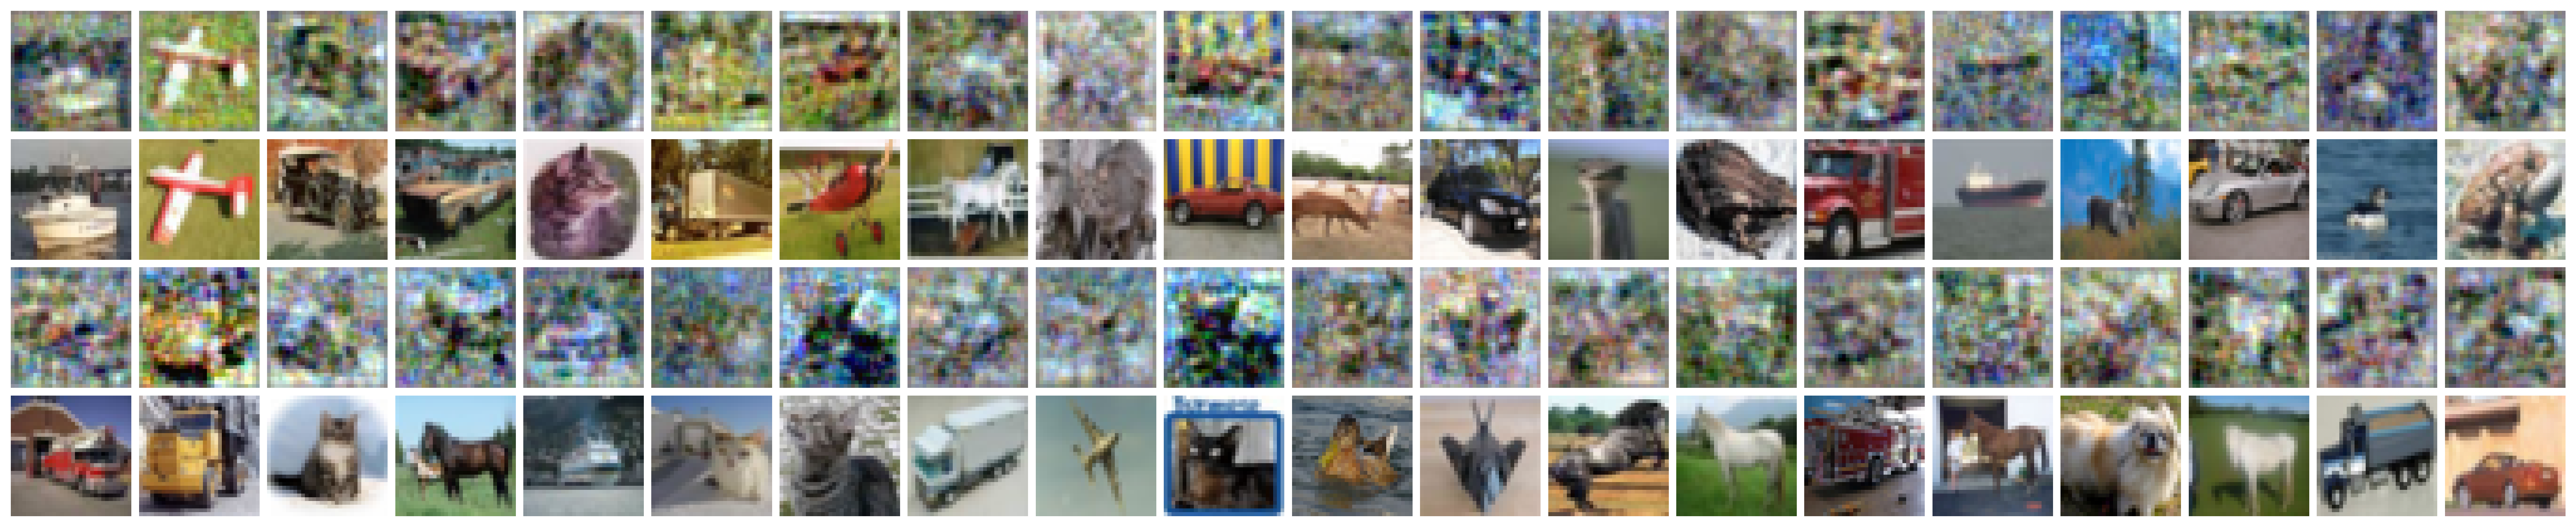

  0%|          | 0/12 [00:03<?, ?it/s]

DONE!


In [4]:
# Find "Good" Resonctructions (as detailed in Appendix B.3):

# Find Nearest Neighbour
xx1 = find_nearest_neighbour(X, Xtrn, search='ncc2', vote='min', use_bb=False, nn_threshold=1000)
# Scale to Images
xx_scaled, yy_scaled = scale(xx1, Xtrn, ds_mean)
# # Sort
xx, yy, ssims, sort_idxs = sort_by_metric(xx_scaled, yy_scaled, sort='ssim')
values = model(Xtrn).data

# Plot
# color_by_labels = Ytrn[sort_idxs]
color_by_labels = None
figpath=None
analysis.plot_table(xx, yy, fig_elms_in_line=20, fig_lines_per_page=4, fig_type='one_above_another', color_by_labels=color_by_labels, figpath=figpath, show=True, dpi=100)

In [5]:
db = model(Xtrn).data
db = db[:,0]
db = db[sort_idxs]
ssims = ssims[sort_idxs]
ssims.shape, db.shape


(torch.Size([500]), torch.Size([500]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


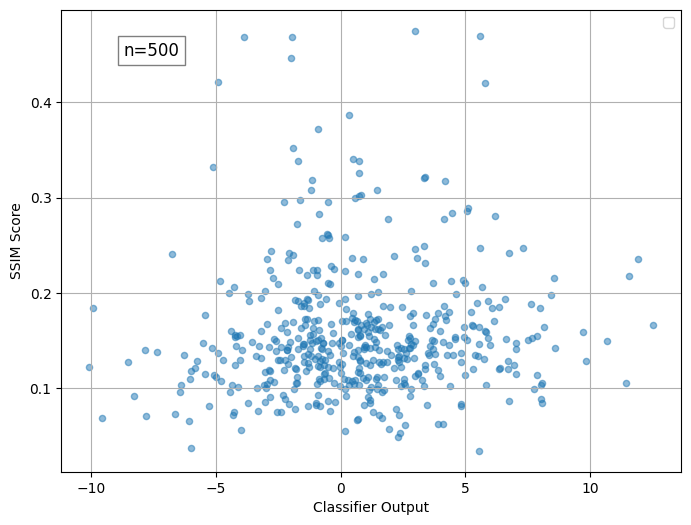

In [6]:
import torch
import matplotlib.pyplot as plt

# Create a scatter plot
plt.figure(figsize=(8, 6))

plt.scatter(db, ssims, marker='o', s=20, alpha=0.5)
# Customize the plot
plt.ylabel('SSIM Score')
plt.xlabel('Classifier Output')
# plt.title('SSIM Score vs. Label Value')
plt.legend()
plt.grid(True)
plt.text(0.1, 0.9, 'n=500', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
# Show the plot
plt.show()
